In [0]:
from fastai.text import *
from tqdm import tqdm_notebook as tqdm

In [0]:
!wget https://github.com/google-research-datasets/gap-coreference/raw/master/gap-development.tsv -q
!wget https://github.com/google-research-datasets/gap-coreference/raw/master/gap-test.tsv -q
!wget https://github.com/google-research-datasets/gap-coreference/raw/master/gap-validation.tsv -q

In [0]:
data_path = Path(".")

In [0]:
train = pd.read_csv(data_path/"gap-development.tsv", sep="\t")
val = pd.read_csv(data_path/"gap-validation.tsv", sep="\t")
test = pd.read_csv(data_path/"gap-test.tsv", sep="\t")

In [5]:
print(len(train), len(val), len(test))

2000 454 2000


In [0]:
train["is_valid"] = True
test["is_valid"] = False
val["is_valid"] = True

df_pretrain = pd.concat([train, test, val])

In [0]:
db = (TextList.from_df(df_pretrain, data_path/"db", cols="Text").split_from_df(col="is_valid").label_for_lm().databunch())

In [0]:
vocab = db.vocab

In [0]:
lm = language_model_learner(db, AWD_LSTM, drop_mult=0.5, pretrained=True)

In [0]:
lm.unfreeze()

In [11]:
lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


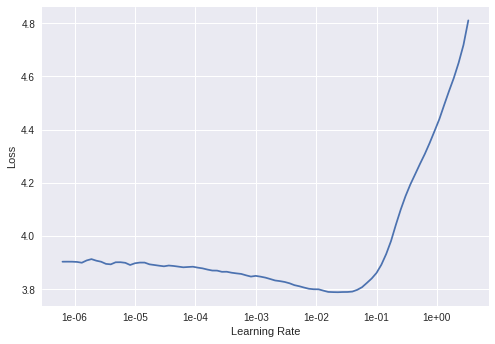

In [12]:
lm.recorder.plot()

In [13]:
lm.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.689631,3.174314,0.397795,00:27
1,3.507948,3.118980,0.405322,00:27
2,3.364824,3.108545,0.405412,00:27


In [14]:
lm.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.258673,3.104271,0.404832,00:27
1,3.202467,3.087334,0.405952,00:27
2,3.096809,3.082487,0.405698,00:27


In [0]:
spacy_tok = SpacyTokenizer("en")
tokenizer = Tokenizer(spacy_tok)

In [16]:
df_pretrain.Text.apply(lambda x: len(tokenizer.process_text(x, spacy_tok))).describe()

count    4454.000000
mean      102.299731
std        30.172871
min        16.000000
25%        82.000000
50%        98.000000
75%       117.000000
max       342.000000
Name: Text, dtype: float64

In [0]:
import spacy
nlp = spacy.blank("en")

def get_token_num_by_offset(s, offset):
  s_pre = s[:offset]
  return len(spacy_tok.tokenizer(s_pre))

# note that 'xxunk' is not special in this sense
special_tokens = ['xxbos','xxfld','xxpad', 'xxmaj','xxup','xxrep','xxwrep']


def adjust_token_num(processed, token_num):
  """
  As fastai tokenizer introduces additional tokens, we need to adjust for them.
  """
  counter = -1
  do_unrep = None
  for i, token in enumerate(processed):
    if token not in special_tokens:
      counter += 1
    if do_unrep:
      do_unrep = False
      if processed[i+1] != ".":
        token_num -= (int(token) - 2) # one to account for the num itself
      else:  # spacy doesn't split full stops
        token_num += 1
    if token == "xxrep":
      do_unrep = True
    if counter == token_num:
      return i
  else:
    counter = -1
    for i, t in enumerate(processed):
      if t not in special_tokens:
        counter += 1
      print(i, counter, t)
    raise Exception(f"{token_num} is out of bounds ({processed})")

In [0]:
def dataframe_to_tensors(df, max_len=512):
  # offsets are: pron_tok_offset, a_tok_offset, a_tok_right_offset, b_tok_offset, b_tok_right_offset
  offsets = list()
  labels = np.zeros((len(df),), dtype=np.int64)
  processed = list()
  for i, row in tqdm(df.iterrows()):
    try:
      text = row["Text"]
      a_offset = row["A-offset"]
      a_len = len(nlp(row["A"]))
      
      b_offset = row["B-offset"]
      b_len = len(nlp(row["B"]))

      pron_offset = row["Pronoun-offset"]
      is_a = row["A-coref"]
      is_b = row["B-coref"]
      a_tok_offset = get_token_num_by_offset(text, a_offset)
      b_tok_offset = get_token_num_by_offset(text, b_offset)
      a_right_offset = a_tok_offset + a_len - 1
      b_right_offset = b_tok_offset + b_len - 1
      pron_tok_offset = get_token_num_by_offset(text, pron_offset)
      tokenized = tokenizer.process_text(text, spacy_tok)[:max_len]
      tokenized = ["xxpad"] * (max_len - len(tokenized)) + tokenized  # add padding
      a_tok_offset = adjust_token_num(tokenized, a_tok_offset)
      a_tok_right_offset = adjust_token_num(tokenized, a_right_offset)
      b_tok_offset = adjust_token_num(tokenized, b_tok_offset)
      b_tok_right_offset = adjust_token_num(tokenized, b_right_offset)
      pron_tok_offset = adjust_token_num(tokenized, pron_tok_offset)
      numericalized = vocab.numericalize(tokenized)
      processed.append(torch.tensor(numericalized, dtype=torch.long))
      offsets.append([pron_tok_offset, a_tok_offset, a_tok_right_offset, b_tok_offset, b_tok_right_offset])
      if is_a:
        labels[i] = 0
      elif is_b:
        labels[i] = 1
      else:
        labels[i] = 2
    except Exception as e:
      print(i)
      raise
  processed = torch.stack(processed)
  offsets = torch.tensor(offsets, dtype=torch.long)
  labels = torch.from_numpy(labels)
  return processed, offsets, labels

In [19]:
train_ds = TensorDataset(*dataframe_to_tensors(test))
valid_ds = TensorDataset(*dataframe_to_tensors(val))
test_ds = TensorDataset(*dataframe_to_tensors(train))

In [0]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

In [0]:
lm.freeze()

In [0]:
encoder_hidden_sz = 400

device = torch.device("cuda")

class CorefResolver(nn.Module):
  def __init__(self, encoder, dropout_p=0.3):
    super(CorefResolver, self).__init__()
    self.encoder = encoder
    self.dropout = nn.Dropout(dropout_p)
    self.hidden2hidden = nn.Linear(encoder_hidden_sz * 2 + 1, 25)
    self.hidden2logits = nn.Linear(50, 3)
    self.relu = nn.ReLU()
    self.activation = nn.LogSoftmax(dim=1)
    self.loss = nn.NLLLoss()
    
  def forward(self, seqs, offsets, labels=None):
    encoded = self.dropout(self.encoder(seqs)[0][2])
    a_q = list()
    b_q = list()
    for enc, offs in zip(encoded, offsets):
      # extract the hidden states that correspond to A, B and the pronoun, and make pairs of those 
      a_repr = enc[offs[2]]
      b_repr = enc[offs[4]]
      a_q.append(torch.cat([enc[offs[0]], a_repr, torch.dot(enc[offs[0]], a_repr).unsqueeze(0)]))
      b_q.append(torch.cat([enc[offs[0]], b_repr, torch.dot(enc[offs[0]], b_repr).unsqueeze(0)]))
    a_q = torch.stack(a_q)
    b_q = torch.stack(b_q)
    # apply the same "detector" layer to both batches of pairs
    is_a = self.relu(self.dropout(self.hidden2hidden(a_q)))
    is_b = self.relu(self.dropout(self.hidden2hidden(b_q)))
    # concatenate outputs of the "detector" layer to get the final probability distribution
    is_a_b = torch.cat([is_a, is_b], dim=1)
    is_logits = self.hidden2logits(self.dropout(self.relu(is_a_b)))

    activation = self.activation(is_logits)
    if labels is not None:
      return activation, self.loss(activation, labels)
    else:
      return activation

In [0]:
enc = lm.model[0]

In [0]:
resolver = CorefResolver(enc)

In [25]:
resolver.to(device)

CorefResolver(
  (encoder): AWD_LSTM(
    (encoder): Embedding(6591, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(6591, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (dropout): Dropout(p=0.3)
  (hidden2hidden): Linear(in_features=801, out_features=25, bias=True)
  (hidden2logits): Linear(in_features=50, out_features=3, bias=True)
  (relu): ReLU()
  (activation): LogSoftmax()
  (loss): NLLLoss()
)

In [0]:
for param in resolver.encoder.parameters():
  param.requires_grad = False

In [0]:
lr = 0.001

loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(resolver.parameters(), lr=lr)

In [0]:
from sklearn.metrics import classification_report

In [0]:
def train_epoch(model, optimizer, train_dl, report_every=10):
  model.train()
  step = 0
  total_loss = 0
  
  for texts, offsets, labels in train_dl:
    texts, offsets, labels = texts.to(device), offsets.to(device), labels.to(device)
    step += 1
    optimizer.zero_grad()
    _, loss = model(texts, offsets, labels)
    total_loss += loss.item()
    
    loss.backward()
    optimizer.step()
    
    if step % report_every == 0:
      print(f"Step {step}, loss: {total_loss/report_every}")
      total_loss = 0
      
def evaluate(model, optimizer, valid_dl, probas=False):
  probas = list()
  model.eval()
  predictions = list()
  total_loss = 0
  all_labels = list()
  with torch.no_grad():
    for texts, offsets, labels in valid_dl:
      texts, offsets, labels = texts.cuda(), offsets.cuda(), labels.cuda()
      preds, loss = model(texts, offsets, labels)
      total_loss += loss.item()
      probas.append(preds.cpu().detach().numpy())
      predictions.extend([i.item() for i in preds.max(1)[1]])
    
    
  print(f"Validation loss: {total_loss/len(valid_dl)}")
  print()
  print(classification_report(valid_dl.dataset.tensors[2].numpy(), predictions))
  if probas:
    return total_loss, np.vstack(probas)
  return total_loss, predictions

In [46]:
total_epoch = 0
best_loss = 1e6

for i in range(3):
  print("Epoch", i + 1)
  total_epoch += 1
  train_epoch(resolver, optimizer, train_dl) 
  loss, labels = evaluate(resolver, optimizer, valid_dl)
  if loss < best_loss:
    best_loss = loss
    print(f"Loss improved, saving {total_epoch}")
    torch.save(resolver.state_dict(), data_path/"model_best.pt")

Epoch 1
Step 10, loss: 0.7229219675064087
Step 20, loss: 0.7855819761753082
Step 30, loss: 0.7172936975955964
Validation loss: 0.8022186279296875

              precision    recall  f1-score   support

           0       0.65      0.72      0.69       187
           1       0.63      0.76      0.69       205
           2       0.00      0.00      0.00        62

   micro avg       0.64      0.64      0.64       454
   macro avg       0.43      0.49      0.46       454
weighted avg       0.55      0.64      0.59       454

Loss improved, saving 1
Epoch 2
Step 10, loss: 0.749944943189621
Step 20, loss: 0.7268320977687835
Step 30, loss: 0.7079075574874878
Validation loss: 0.7839768052101135

              precision    recall  f1-score   support

           0       0.67      0.74      0.70       187
           1       0.65      0.76      0.70       205
           2       0.67      0.06      0.12        62

   micro avg       0.66      0.66      0.66       454
   macro avg       0.66      0

In [0]:
for param in resolver.encoder.parameters():
  param.requires_grad = True

In [0]:
lr = 3e-4
optimizer = torch.optim.Adam(resolver.parameters(), lr=lr)

In [33]:
for i in range(6):
  print("Epoch", i + 1)
  total_epoch += 1
  train_epoch(resolver, optimizer, train_dl)
  loss, labels = evaluate(resolver, optimizer, valid_dl)
  if loss < best_loss:
    best_loss = loss
    print(f"Loss improved, saving {total_epoch}")
    torch.save(resolver.state_dict(), data_path/"model_best.pt")

Epoch 1
Step 10, loss: 0.8262440204620362
Step 20, loss: 0.8634966731071472
Step 30, loss: 0.8171249032020569
Validation loss: 0.8485277533531189

              precision    recall  f1-score   support

           0       0.60      0.79      0.68       187
           1       0.65      0.66      0.66       205
           2       0.00      0.00      0.00        62

   micro avg       0.62      0.62      0.62       454
   macro avg       0.42      0.48      0.44       454
weighted avg       0.54      0.62      0.57       454

Loss improved, saving 4
Epoch 2


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Step 10, loss: 0.7993718802928924
Step 20, loss: 0.8165597200393677
Step 30, loss: 0.7772640407085418
Validation loss: 0.8252914587656657

              precision    recall  f1-score   support

           0       0.61      0.79      0.69       187
           1       0.66      0.68      0.67       205
           2       0.00      0.00      0.00        62

   micro avg       0.63      0.63      0.63       454
   macro avg       0.42      0.49      0.45       454
weighted avg       0.55      0.63      0.59       454

Loss improved, saving 5
Epoch 3


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Step 10, loss: 0.7489581048488617
Step 20, loss: 0.7606636583805084
Step 30, loss: 0.7749382495880127
Validation loss: 0.8165390292803446

              precision    recall  f1-score   support

           0       0.62      0.79      0.70       187
           1       0.66      0.70      0.68       205
           2       0.00      0.00      0.00        62

   micro avg       0.64      0.64      0.64       454
   macro avg       0.43      0.49      0.46       454
weighted avg       0.55      0.64      0.59       454

Loss improved, saving 6
Epoch 4


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Step 10, loss: 0.7776200354099274
Step 20, loss: 0.7454776167869568
Step 30, loss: 0.7503041088581085
Validation loss: 0.8011608521143595

              precision    recall  f1-score   support

           0       0.63      0.79      0.70       187
           1       0.66      0.72      0.69       205
           2       0.00      0.00      0.00        62

   micro avg       0.65      0.65      0.65       454
   macro avg       0.43      0.50      0.46       454
weighted avg       0.56      0.65      0.60       454

Loss improved, saving 7
Epoch 5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Step 10, loss: 0.7194176375865936
Step 20, loss: 0.719692075252533
Step 30, loss: 0.7611520946025848
Validation loss: 0.8032508412996928

              precision    recall  f1-score   support

           0       0.64      0.75      0.69       187
           1       0.63      0.71      0.67       205
           2       0.00      0.00      0.00        62

   micro avg       0.63      0.63      0.63       454
   macro avg       0.42      0.49      0.45       454
weighted avg       0.55      0.63      0.59       454

Epoch 6


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Step 10, loss: 0.7390532732009888
Step 20, loss: 0.7216969132423401
Step 30, loss: 0.6626725018024444
Validation loss: 0.8022660255432129

              precision    recall  f1-score   support

           0       0.65      0.72      0.68       187
           1       0.63      0.76      0.69       205
           2       0.50      0.02      0.03        62

   micro avg       0.64      0.64      0.64       454
   macro avg       0.59      0.50      0.47       454
weighted avg       0.62      0.64      0.60       454



In [0]:
resolver.load_state_dict(torch.load(data_path/"model_best.pt"))

In [35]:
loss, res = evaluate(resolver, optimizer, test_dl, True)
res_s = np.exp(res)  # don't forget that we have log-softmax outputs:
submission = pd.DataFrame(res_s, index=train["ID"], columns=["A", "B", "NEITHER"])
submission.to_csv("submission.csv", index="id")

Validation loss: 0.7291654996455662

              precision    recall  f1-score   support

           0       0.63      0.81      0.71       874
           1       0.72      0.68      0.70       925
           2       0.00      0.00      0.00       201

   micro avg       0.67      0.67      0.67      2000
   macro avg       0.45      0.50      0.47      2000
weighted avg       0.61      0.67      0.63      2000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
test.head(5)

,ID,Text,Pronoun,Pronoun-offset,A,A-offset,A-coref,B,B-offset,B-coref,URL,is_valid
0,test-1,Upon their acceptance into the Kontinental Hoc...,His,383,Bob Suter,352,False,Dehner,366,True,http://en.wikipedia.org/wiki/Jeremy_Dehner,False
1,test-2,"Between the years 1979-1981, River won four lo...",him,430,Alonso,353,True,Alfredo Di St*fano,390,False,http://en.wikipedia.org/wiki/Norberto_Alonso,False
2,test-3,Though his emigration from the country has aff...,He,312,Ali Aladhadh,256,True,Saddam,295,False,http://en.wikipedia.org/wiki/Aladhadh,False
3,test-4,"At the trial, Pisciotta said: ``Those who have...",his,526,Alliata,377,False,Pisciotta,536,True,http://en.wikipedia.org/wiki/Gaspare_Pisciotta,False
4,test-5,It is about a pair of United States Navy shore...,his,406,Eddie,421,True,Rock Reilly,559,False,http://en.wikipedia.org/wiki/Chasers,False


In [42]:
train.head()

,ID,Text,Pronoun,Pronoun-offset,A,A-offset,A-coref,B,B-offset,B-coref,URL,is_valid
0,development-1,Zoe Telford -- played the police officer girlf...,her,274,Cheryl Cassidy,191,True,Pauline,207,False,http://en.wikipedia.org/wiki/List_of_Teachers_...,True
1,development-2,"He grew up in Evanston, Illinois the second ol...",His,284,MacKenzie,228,True,Bernard Leach,251,False,http://en.wikipedia.org/wiki/Warren_MacKenzie,True
2,development-3,"He had been reelected to Congress, but resigne...",his,265,Angeloz,173,False,De la Sota,246,True,http://en.wikipedia.org/wiki/Jos%C3%A9_Manuel_...,True
3,development-4,The current members of Crime have also perform...,his,321,Hell,174,False,Henry Rosenthal,336,True,http://en.wikipedia.org/wiki/Crime_(band),True
4,development-5,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,437,Kitty Oppenheimer,219,False,Rivera,294,True,http://en.wikipedia.org/wiki/Jessica_Rivera,True
